# Семинар 5. SVM. PCA

<a id="Content"></a>
# Содержание
0. [SVM](#0)
   - [Визуализация работы SVM](#0.1)
   - [Влияние константы C](#0.2)
   - [Линейно неразделимая выборка и kernel trick](#0.3)
   - [Реализация SVM с SGD](#0.4)
1. [PCA](#1)
   - [Построение оптимального базиса](#1.1)
   - [Двумерный пример](#1.2)
   - [Визуализация многомерных данных](#1.3)
   - [Снижение размерности данных](#1.4)
   - [Предобработка данных](#1.5)
2. [Сжатие изображений с помощью SVD](#2)
3. [Полезные ссылки](#3)

In [73]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # "Support vector classifier"

<a id="0"></a>
# 0. SVM

![image.png](img/svm.png)

$$M = y_{i}(x_{i}^Tw)$$
$$y_{i} \in C, C=\left\{-1, 1 \right\} $$

![img](img/losses.png)

SVM: $$\frac{1}{2} ||w||_2 + C \frac{1}{n}\sum_{i=1}^{n}\max(0, 1 - y_i (<w,X_i> + b)) \to \min_{w,b}$$

LogisticRegression: $$||w||_2 + \sum_{i=1}^{n}log(1 + e^{-y_i(<w,X_i>)))}) \to \min_{w}$$

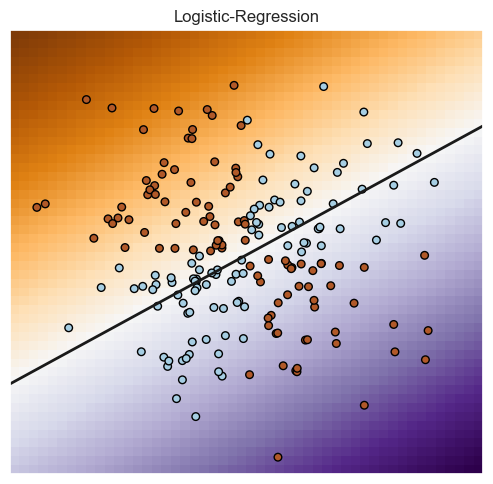

In [74]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
plt.figure(figsize=(10, 5))
clf = LogisticRegression().fit(X,Y)

# plot the decision function for each datapoint on the grid
Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
Z = Z.reshape(xx.shape)

plt.subplot(1, 2, 1)
image = plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=["k"])
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.title("Logistic-Regression")

plt.tight_layout()
plt.show()

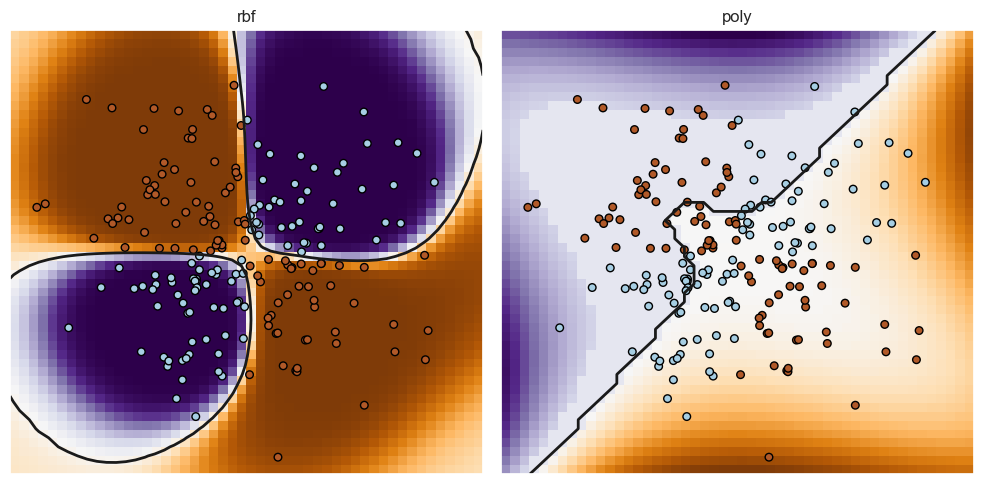

In [75]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
plt.figure(figsize=(10, 5))
kernels = ["rbf","poly"]
for i, kernel in enumerate(kernels):
    clf = SVC(kernel=kernel, C=100, probability=True).fit(X, Y)

    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i + 1)
    image = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=["k"])
    plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.title(
    (clf.kernel),
        fontsize=12,
    )

plt.tight_layout()
plt.show()

<a id="0.1"></a>
## 0.1. Визуализация работы SVM

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

In [79]:
X, Y = make_blobs(n_samples=300, centers=2, random_state=45, cluster_std=2)
Y[Y == 0] = -1 # for convenience with formulas

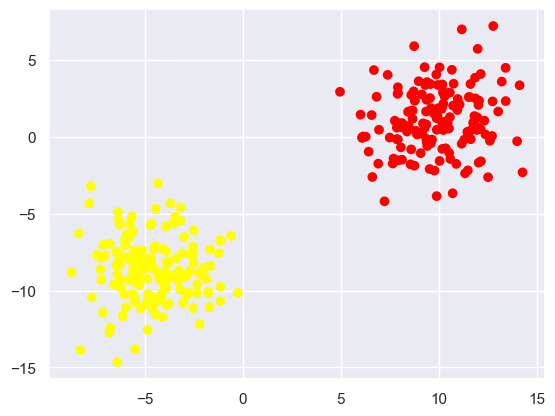

In [80]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='autumn')

In [81]:
model = SVC(kernel='linear', C=10000000) # при C -> +inf приходим к лоссу для постановки задачи линейно разделимых классов
model.fit(X, Y)

SVC(C=10000000, kernel='linear')

In [82]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',edgecolor="black"); 
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

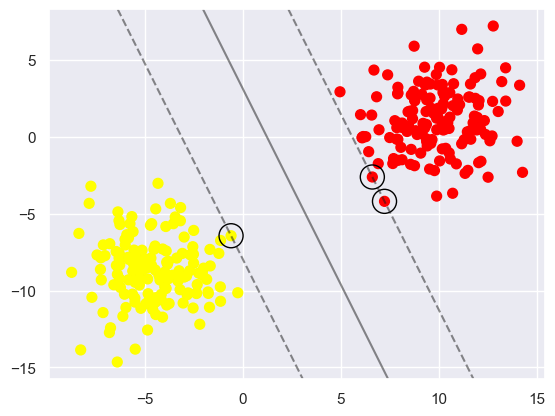

In [83]:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [84]:
model.support_vectors_

array([[ 7.23696496, -4.20286272],
       [ 6.61582898, -2.62037723],
       [-0.59008413, -6.43890066]])

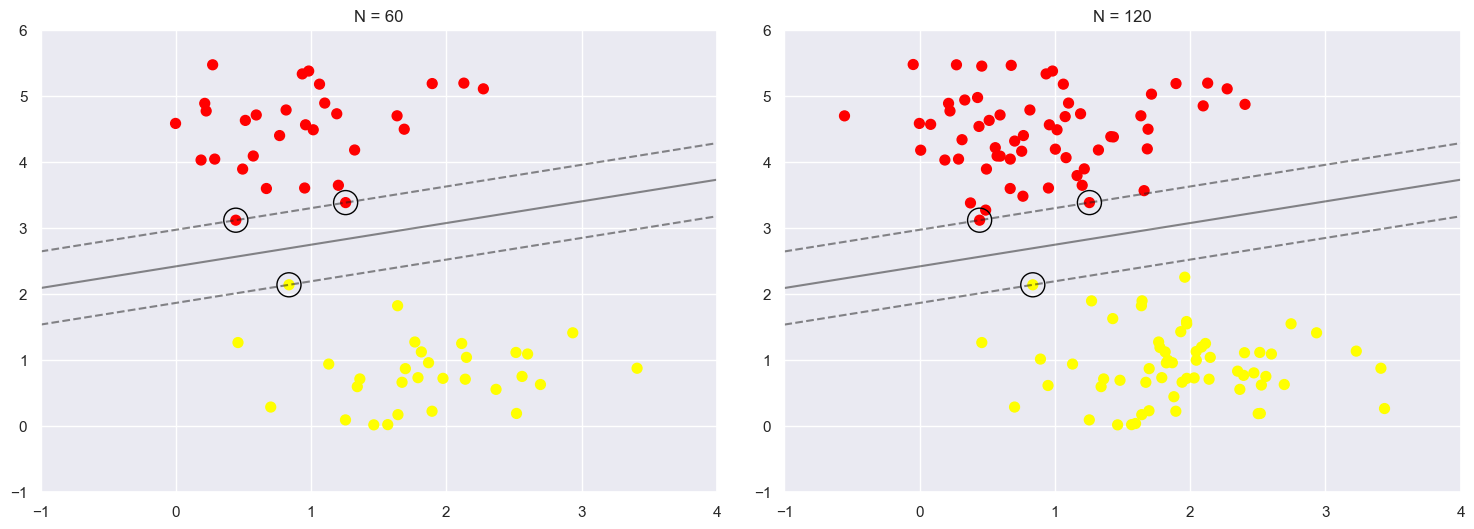

In [85]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

На левом графике мы видим модель и опорные векторы для 60 тренировочных точек. На правом графике мы удвоили количество тренировочных точек, но модель не изменилась: три опорных вектора с левого графика по-прежнему являются опорными векторами для правого графика. То есть только те самые support vectors влияют на margin и положение разделяющей гиперплоскости. Эта нечувствительность к точному поведению с удалёнными точками является одной из сильных сторон SVM-модели.

<a id="0.2"></a>
## 0.2. Влияние константы C

SVM: $$\frac{1}{2} ||w||_2 + C \frac{1}{n}\sum_{i=1}^{n}\max(0, 1 - y_i (<w,X_i> + b)) \to \min_{w,b}$$

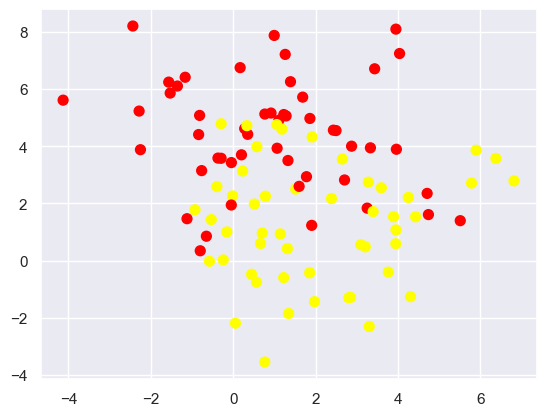

In [86]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

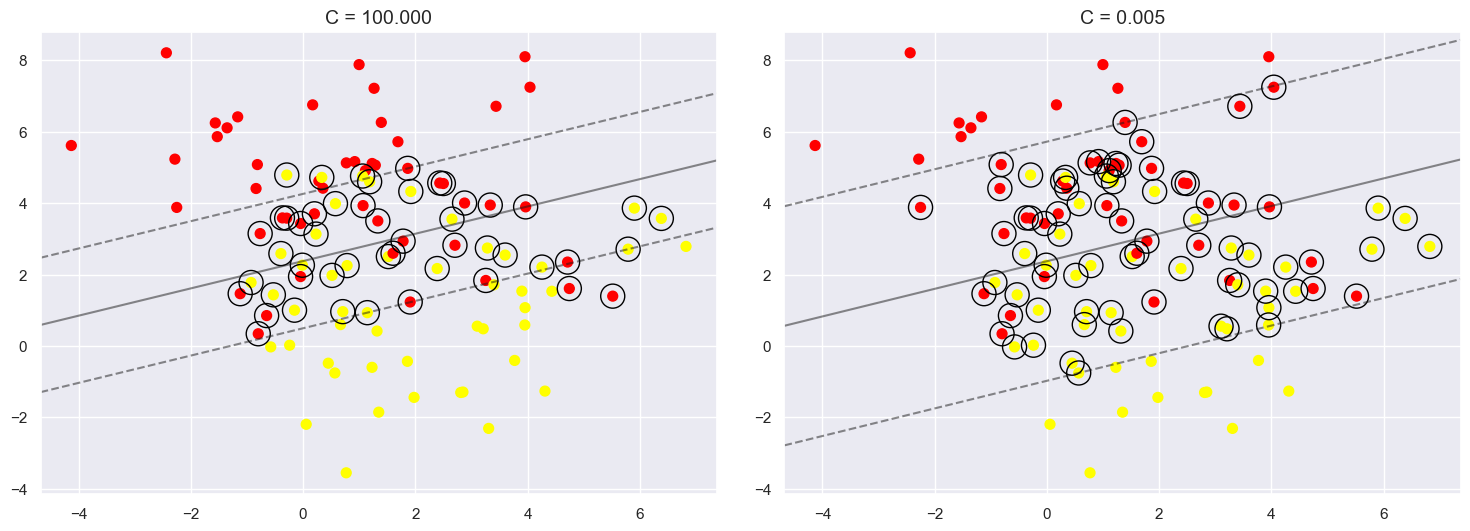

In [100]:
y[y == 0] = -1
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100.0, 0.005]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.3f}'.format(C), size=14)

<a id="0.3"></a>
## 0.3. Линейно неразделимая выборка и kernel trick

In [101]:
from sklearn.datasets import make_circles

In [102]:
X, y = make_circles(100, factor=.1, noise=.1)
y[y == 0] = -1

D:\Anaconda3\Lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


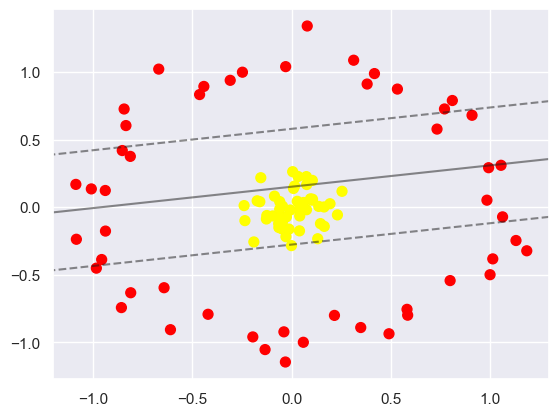

In [103]:
clf = SVC(kernel='linear', C=100000, max_iter=50).fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Linear SVM __primal__ optimization problem can be formulated as

$$\frac{1}{2} ||w||_2 + C \frac{1}{n}\sum_{i=1}^{n}\max(0, 1 - y_i (<w,X_i> + b)) \to \min_{w,b}$$
$$where$$ $${loss_{hinge}} = \max(0, 1 - y_i (<w,X_i> + b))$$

This problem can be solved with gradient or sub-gradien methods.

-----
Whereas __dual__ optimization problem formulates as follows:

$$
\sum_{i=1}^n \alpha_{i} - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n y_i \alpha_{i} (X_i \cdot X_j ) y_j \alpha_{j} \to \max_{\alpha_{1},...,\alpha_{n}}  \text{subject to} 
\sum_{i=1}^n \alpha_{i}y_i=0, \
0 \leq \alpha_{i} \leq \frac{1}{2n\lambda} \forall i
$$

Where $W = \sum_{i=1}^n \alpha_{i} y_i X_i$.

In this quadratic optimization problem we can use kernel trick: <br/>
introduce fucntion $K(X_i, X_j) = \phi (X_i) \phi (X_j)$ and change dot products in our optimization problem

Then we have 

$$
\sum_{i=1}^n \alpha_{i} - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n y_i \alpha_{i} K(X_i, X_j) y_j \alpha_{j} \to \max_{\alpha_{1},...,\alpha_{n}} 
\text{subject to} 
\sum_{i=1}^n \alpha_{i}y_i=0, \ 
0 \leq \alpha_{i} \leq \frac{1}{2n\lambda} \forall i
$$

$W = \sum_{i=1}^n \alpha_{i} y_i \phi(X_i)$

In quadratic programming we can straightforwardly add kernel function, but it is not that simple, if we want to use gradient algorithms.

$$K(X_i, X_j) = (X_i, X_j)^2 - quadratic$$
$$K(X_i, X_j) = ((X_i, X_j) + shift)^d - poly$$
$$K(X_i, X_j) = e^{-\gamma*||X_i - X_j||^2} - rbf$$

----
However primal optimization problem with kernels can be formulated like (see [Olivier Chapelle, 2006](https://www.cse.iitb.ac.in/~soumen/readings/papers/Chappelle2006PrimalSVM.pdf) )):

$$f(x) = \sum_{i=1}^n \beta_i K(x_i, x)$$

$$K: K_{i,j} = K(x_i, x_j)$$

$$ \lambda \vec{\beta^T} K \vec{\beta} + \sum_{i=1}^n L(y_i, K_i^T \vec{\beta}) \to \min_{\vec{\beta}}$$

where L is Hinge loss: $L(y_i, K_i^T \vec{\beta}) = \max(0, 1 - y_i (K_i^T \vec{\beta}))$

In [105]:
clf = SVC(kernel='rbf', degree=20, C=1e6, max_iter=10000)
y[y == 0] = -1
clf.fit(X, y)

SVC(C=1000000.0, degree=20, max_iter=10000)

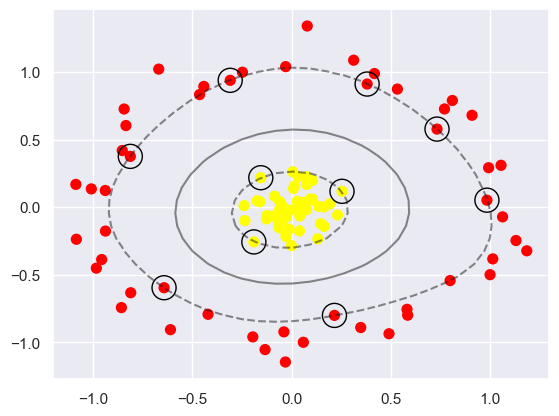

In [106]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

<a id="0.4"></a>
## 0.4. Реализация SVM с SGD

In [134]:
import torch
from torch.nn import MSELoss, Parameter

# The data function is: y = x + 10
x_train = torch.tensor([1, 2, 3, 4])
y_train = torch.tensor([11, 12, 13, 14], dtype=torch.float)

# Simple Linear Regression: y = a + bx
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)

# If we use nn.Module to create a model, it will model.parameters()
model = [Parameter(a), Parameter(b)]

lr=0.01
criterion = MSELoss()
optimizer = torch.optim.SGD(model, lr=lr)

loss_history = []

print(f"PARAM 0 before: {model[0]}")
print(f"PARAM 1 before: {model[1]}\n")

for epoch in range(100):
    print(f"--------Epoch {epoch}--------")
    # Remove the grad computed in the last step
    print(f"param 0 grad before zero_grad(): {model[0].grad}")
    print(f"param 1 grad before zero_grad(): {model[1].grad}\n")
    optimizer.zero_grad()
    print(f"param 0 grad after zero_grad(): {model[0].grad}")
    print(f"param 1 grad after zero_grad(): {model[1].grad}\n")

    
    # Run a + bx
    y_predicted = model[0] + model[1] * x_train
    
    
    loss = criterion(y_predicted, y_train) # считаем ошибку 
    
    loss_history.append(loss.item())
    
    loss.backward() # считаем градиенты 
    

    print(f"Loss {loss}\n")
    print(f"before optimizer.step() param 0: {model[0]}")
    print(f"before optimizer.step() param 1: {model[1]}\n")
    
    param0 = model[0].cpu().detach().clone()
    param1 = model[1].detach().clone()
    
    optimizer.step() # обновляем параметры 
    print(f"after optimizer.step() param 0 grad: {model[0].grad}")
    print(f"after optimizer.step() param 1 grad: {model[1].grad}\n")
    
    print(f"after optimizer.step() 0: {model[0]}, scratch: {param0 - lr*model[0].grad}")
    print(f"after optimizer.step() 1: {model[1]}, scratch: {param1 - lr*model[1].grad}\n")
    print(f"----------------------------------------------")

PARAM 0 before: Parameter containing:
tensor([0.5201], requires_grad=True)
PARAM 1 before: Parameter containing:
tensor([-0.6035], requires_grad=True)

--------Epoch 0--------
param 0 grad before zero_grad(): None
param 1 grad before zero_grad(): None

param 0 grad after zero_grad(): None
param 1 grad after zero_grad(): None

Loss 185.15423583984375

before optimizer.step() param 0: Parameter containing:
tensor([0.5201], requires_grad=True)
before optimizer.step() param 1: Parameter containing:
tensor([-0.6035], requires_grad=True)

after optimizer.step() param 0 grad: tensor([-26.9771])
after optimizer.step() param 1 grad: tensor([-71.4513])

after optimizer.step() 0: Parameter containing:
tensor([0.7899], requires_grad=True), scratch: tensor([0.7899])
after optimizer.step() 1: Parameter containing:
tensor([0.1111], requires_grad=True), scratch: tensor([0.1111])

----------------------------------------------
--------Epoch 1--------
param 0 grad before zero_grad(): tensor([-26.9771])


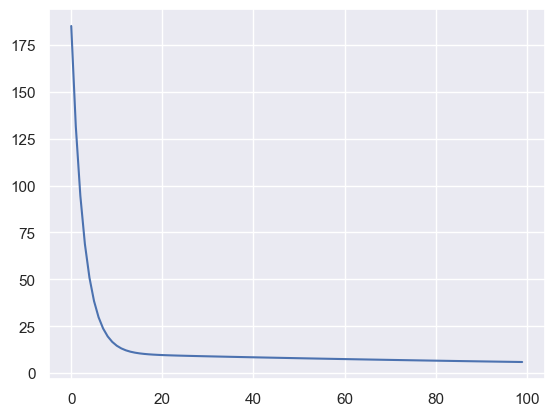

In [135]:
plt.plot(loss_history)

In [136]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
y[y == 0] = -1

**Задание 0:** Реализовать Hinge Loss

In [137]:
def hinge_loss(scores, labels):
    '''Mean loss for batch of objects
    '''
    assert len(scores.shape) == 1
    assert len(labels.shape) == 1
    
    return sum([max(0, 1 - scores[i]*labels[i]) for i in range(len(scores))])/len(scores) ### YOUR CODE HERE

**Задание 1:** Реализовать линейное ядро

In [138]:
class SVM(BaseEstimator, ClassifierMixin):
    @staticmethod
    def linear(x_1, x_2):
        '''Computes linear kernel for batches of objects
        
        Args:
            x_1: array shaped `(#samples_1, #features)`
            x_2: array shaped `(#samples_2, #features)`
        Returns:
            kernel function values for all pairs of samples from x_1 and x_2
            shaped `(#samples_1, #samples_2)`
        '''
        return x_1 @ x_2.T ### YOUR CODE HERE
    
    def __init__(
        self,
        lr: float=1e-3,
        epochs: int=2,
        batch_size: int=64,
        lmbd: float=1e-4,
        kernel_function=None,
        verbose: bool=False,
    ):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmbd = lmbd
        self.kernel_function = kernel_function or SVM.linear
        self.verbose = verbose
        self.fitted = False

    def __repr__(self):
        return 'SVM model, fitted: {self.fitted}'

    def fit(self, X, Y):
        assert (np.abs(Y) == 1).all()
        n_obj = len(X)
        X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)
        K = self.kernel_function(X, X).float()

        self.betas = torch.full((n_obj, 1), fill_value=0.001, dtype=X.dtype, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True) # I've also add bias to the model
           
        optimizer = optim.SGD((self.betas, self.bias), lr=self.lr)
        for epoch in range(self.epochs):
            perm = torch.randperm(n_obj)  # Generate a set of random numbers of length: sample size
            sum_loss = 0.                 # Loss for each epoch
            for i in range(0, n_obj, self.batch_size):
                batch_inds = perm[i:i + self.batch_size]
                x_batch = X[batch_inds]   # Pick random samples by iterating over random permutation
                y_batch = Y[batch_inds]   # Pick the correlating class
                k_batch = K[batch_inds]
                
                optimizer.zero_grad()     # Manually zero the gradient buffers of the optimizer
                
                preds = k_batch @ self.betas + self.bias 
                preds = preds.flatten()
                loss = self.lmbd * self.betas[batch_inds].T @ k_batch @ self.betas + hinge_loss(preds, y_batch)
                loss.backward()           # Backpropagation
                optimizer.step()          # Optimize and adjust weights

                sum_loss += loss.item()   # Add the loss

            if self.verbose: print("Epoch " + str(epoch) + ", Loss: " + str(sum_loss / self.batch_size))

        self.X = X
        self.fitted = True
        return self

    def predict_scores(self, batch):
        with torch.no_grad():
            batch = torch.from_numpy(batch).float()
            K = self.kernel_function(batch, self.X)
            return (K @ self.betas + self.bias).flatten()

    def predict(self, batch):
        scores = self.predict_scores(batch)
        answers = np.full(len(batch), -1, dtype=np.int64)
        answers[scores > 0] = 1
        return answers

In [139]:
model = SVM(epochs=10, verbose=True)

In [140]:
model.fit(X, y)

Epoch 0, Loss: 0.04175555892288685
Epoch 1, Loss: 0.02592167630791664
Epoch 2, Loss: 0.04662571661174297
Epoch 3, Loss: 0.011987275443971157
Epoch 4, Loss: 0.015382963698357344
Epoch 5, Loss: 0.020444130524992943
Epoch 6, Loss: 0.01650500949472189
Epoch 7, Loss: 0.018819805700331926
Epoch 8, Loss: 0.012365193106234074
Epoch 9, Loss: 0.012575954664498568


SVM model, fitted: {self.fitted}

In [141]:
predictions = model.predict(X)
predictions.shape

(100,)

In [142]:
accuracy_score(y, predictions)

0.82

<a id="1"></a>
# 1. PCA

Постановки задачи метода главных компонент:
1. Выбор k наиболее дисперстных направлений.
2. Построить такое ортогональное преобразование координат, что в результате корреляции между отдельными координатами обратятся в ноль. Таким образом, задача сводится к диагонализации матрицы ковариаций, что эквивалентно нахождению сингулярного разложения матрицы исходных данных.
3. Нахождение такой $k$-мерной плоскости в $d$-мерном признаковом пространстве, что ошибка проецирования объектов на нее будет минимальной. Направляющие векторы этой плоскости и будут первыми $k$ главными компонентами.

![img](img/pca_good_bad_direction.png)

Решаемые задачи:
1. Снижение размерности.
2. Визуализация.
3. Предобработка данных

<a id="1.1"></a>
## 1.1. Построение оптимального базиса

PCA строит оптимальный базис, а не выбирает базисные вектора (признаки).

### Алгоритм PCA
1. Пусть $F$ - матрица признаков lxn, то есть мы имеем n признаков для l объектов.
2. Посчитаем матрицу Грамма для матрицы признаков: $\hat{F} = \frac{1}{l}*{F^T*F}$
3. Из $det(\hat{F} - \lambda*E) = 0$ найдём собственные числа $\lambda_{i}$ и вектора $u_{i}$
4. Разположим $\lambda_{i}$ в порядке убывания, то есть $\lambda_{1} \geq \lambda_{2} \geq ... \geq \lambda_{n}$
5. Тогда $\lambda_{i}$ - дисперсия разброса проекции обучающей выборки на ось $u_{i}$, то есть наибольшее количество информации будет приходиться на $u_{1}$

![img](img/most_important.jpg)

6. ИЛИ Найти сингулярное разложение матрицы $F$: $F = VDU^T$, где в матрице $D$ по диагонали располагаются корни из собственных чисел в отсортированном порядке, матрица $U^T$ состоит из собственных векторов, а матрица $V$ - начальная некоррелированная матрица распределения множества точек

![img](img/svd_diag_matrix.png)

7. Тогда новое признаковое пространство будет выглядеть: $G = F*U$

<a id="1.2"></a>
## 1.2. Двумерный пример

Чтобы понять геометрический смысл главных компонент, рассмотрим в качестве примера выборку из двухмерного нормального распределения с явно выраженным "главным" направлением. Выделим в ней главные компоненты и посмотрим, какую долю дисперсии объясняет каждая из них.

In [32]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# fancy progress bar
from tqdm.auto import tqdm
from sklearn import preprocessing

C:\Users\Arina\AppData\Local\Temp\ipykernel_6612\3129355593.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = np.random.multivariate_normal(mean, cov, 300)


Proportion of variance explained by each component:
1st component - 0.93,
2nd component - 0.07

Directions of principal components:
1st component: [-0.7076308   0.70658237] 
2nd component: [-0.70658237 -0.7076308 ]


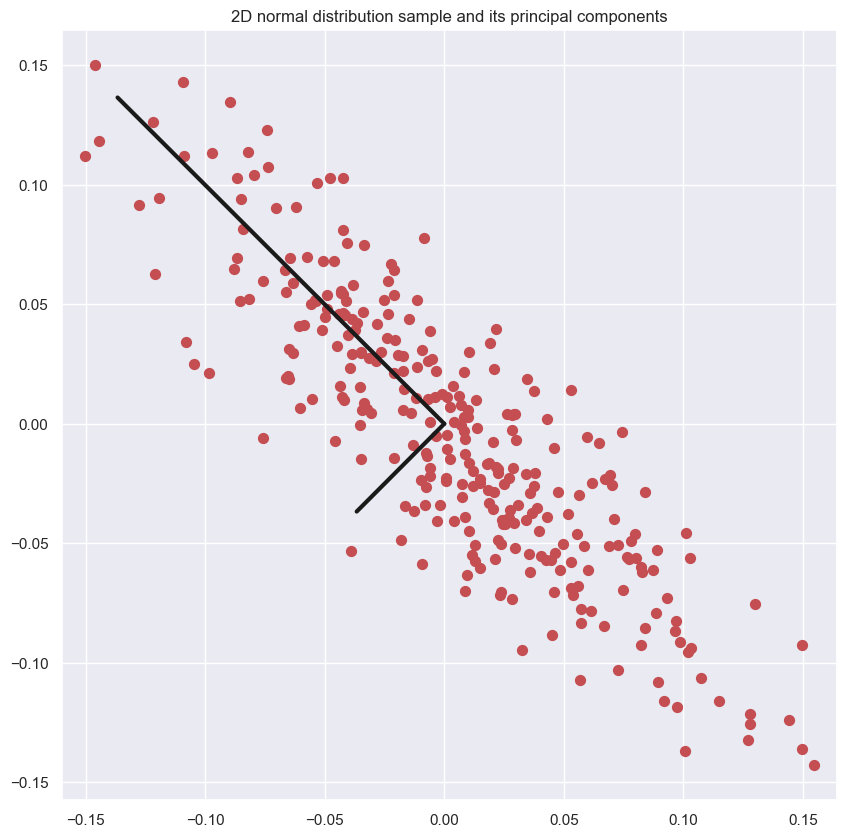

In [33]:
np.random.seed(0)
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])
X = np.random.multivariate_normal(mean, cov, 300)
X = preprocessing.normalize(X, axis=0)

pca = PCA()
pca.fit(X)
print('Proportion of variance explained by each component:\n' +\
      '1st component - %.2f,\n2nd component - %.2f\n' %
      tuple(pca.explained_variance_ratio_))
print('Directions of principal components:\n' +\
      '1st component:', pca.components_[0],
      '\n2nd component:', pca.components_[1])

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=50, c='r')
for l, v in zip(pca.explained_variance_ratio_, pca.components_):
    d = 0.2*np.sqrt(l) * v
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=3)
plt.axis('equal')
plt.title('2D normal distribution sample and its principal components')
plt.show()

Первая главная компонента (ей соответствует более длинный вектор) объясняет более 90% дисперсии исходных данных. Это говорит о том, что она содержит в себе почти всю информацию о расположении выборки в пространстве, и вторая компонента может быть опущена. Спроецируем данные на первую компоненту.

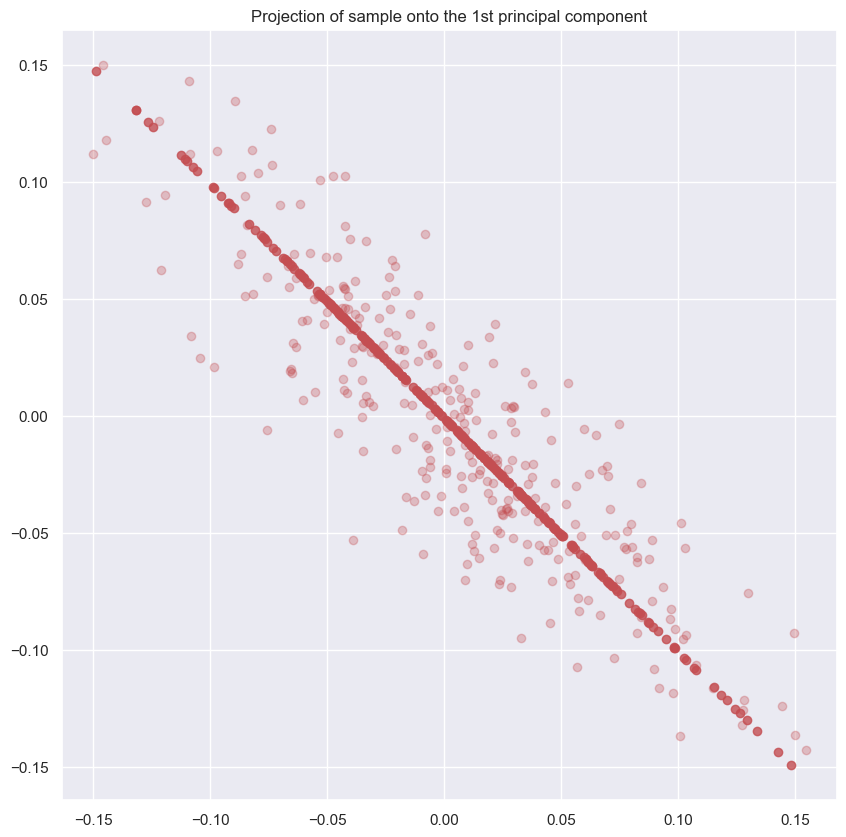

In [34]:
# Keep enough components to explain 90% of variance
pca = PCA(0.9)
X_reduced = pca.fit_transform(X)

# Map the reduced data into the initial feature space
X_new = pca.inverse_transform(X_reduced)

plt.figure(figsize=(10,10))
plt.plot(X[:, 0], X[:, 1], 'or', alpha=0.3)
plt.plot(X_new[:, 0], X_new[:, 1], 'or', alpha=0.8)
plt.axis('equal')
plt.title('Projection of sample onto the 1st principal component')
plt.show()

Мы понизили размерность данных вдвое, при этом сохранив наиболее значимые черты. В этом заключается основной принцип понижения размерности – приблизить многомерный набор данных с помощью данных меньшей размерности, сохранив при этом как можно больше информации об исходных данных.

<a id="1.3"></a>
## 1.3. Визуализация многомерных данных

Одним из применений метода главных компонент является визуализации многомерных данных в двухмерном (или трехмерном) пространстве. Для этого необходимо взять первые две главных компоненты и спроецировать данные на них. При этом, если признаки имеют различную природу, их следует отмасштабировать. Основные способы масштабирования:
- На единичную дисперсию по осям (масштабы по осям равны средним квадратичным отклонениям — после этого преобразования ковариационная матрица совпадает с матрицей коэффициентов корреляции).
- На равную точность измерения (масштаб по оси пропорционален точности измерения данной величины).
- На равные требования в задаче (масштаб по оси определяется требуемой точностью прогноза данной величины или допустимым её искажением — уровнем толерантности). 

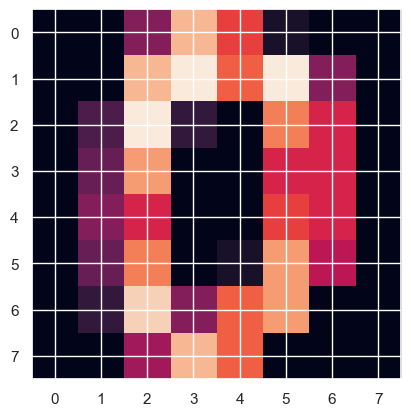

In [38]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

plt.imshow(X[0].reshape(8,8))

Projecting 64-dimensional data to 2D


C:\Users\Arina\AppData\Local\Temp\ipykernel_6612\3308619644.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


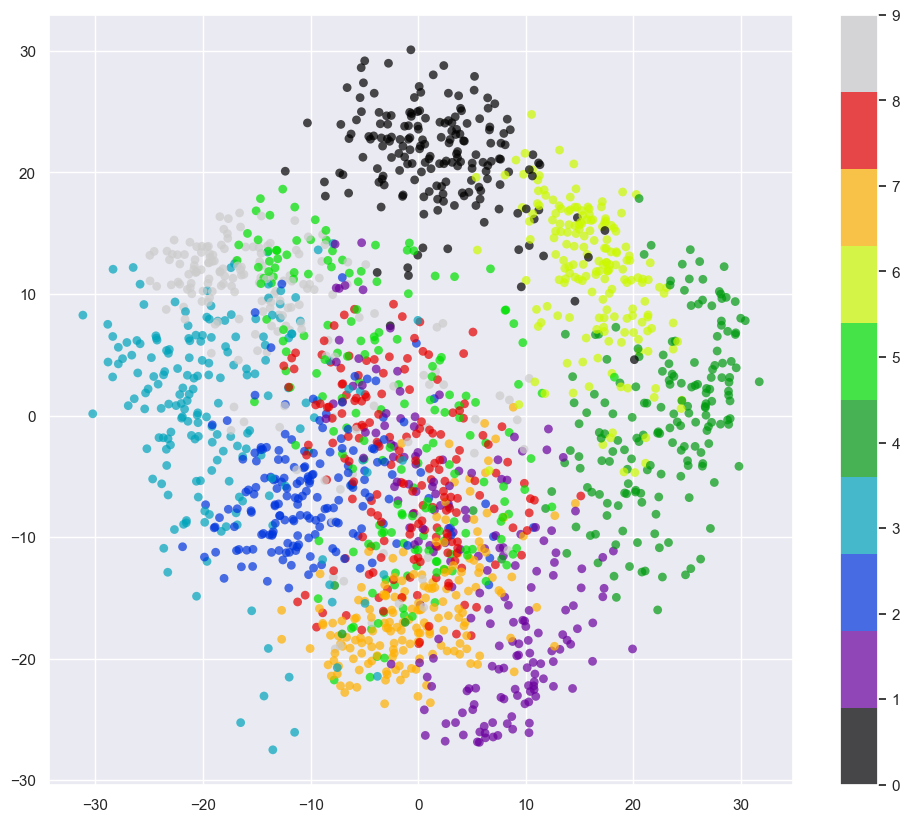

In [39]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

Полученная картинка позволяет увидеть зависимости между различными цифрами. Например, цифры 0 и 6 располагаются в соседних кластерах, что говорит об их схожем написании. Наиболее "разбросанный" (по другим кластерам) – это кластер, соответствующий цифре 8, что говорит о том, что она имеет много различных написаний, делающих её схожей со многими другими цифрами.

Посмотрим, как выглядят первые две главные компоненты.

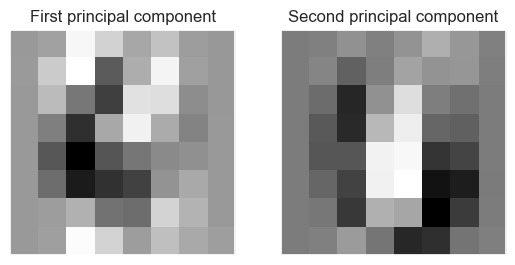

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

im = pca.components_[0]
ax1.imshow(im.reshape((8, 8)), cmap='binary')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('First principal component')

im = pca.components_[1]
ax2.imshow(im.reshape((8, 8)), cmap='binary')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Second principal component')
plt.show()

<a id="1.4"></a>
## 1.4. Снижение размерности данных

Другим применением PCA является снижение размерности данных для их сжатия. Рассмотрим, как влияет число отбираемых главных компонент (на которые осуществляется проекция) на качество восстановления исходного изображения.

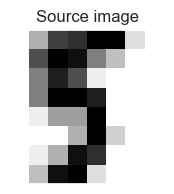

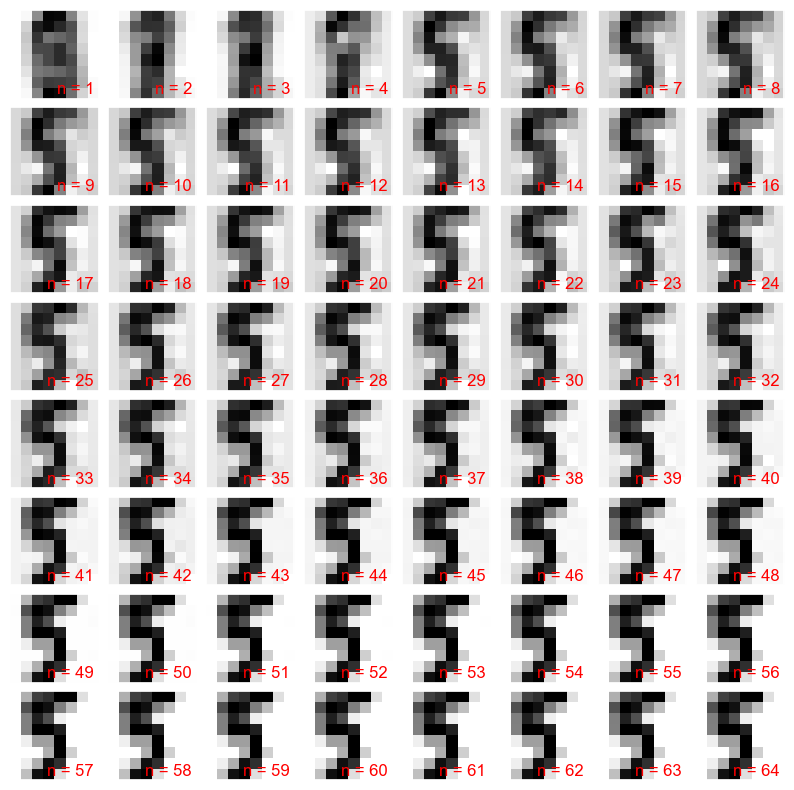

In [43]:
plt.figure(figsize=(4,2))
plt.imshow(X[15].reshape((8, 8)), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.title('Source image')
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[15].reshape(1, -1)))

    ax.imshow(im.reshape((8, 8)), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='red')
    ax.set_xticks([])
    ax.set_yticks([])

Как понять, какое число главных компонент достаточно оставить? Для этого может оказаться полезным следующий график, выражающий зависимость общей доли объясняемой дисперсии от числа главных компонент.

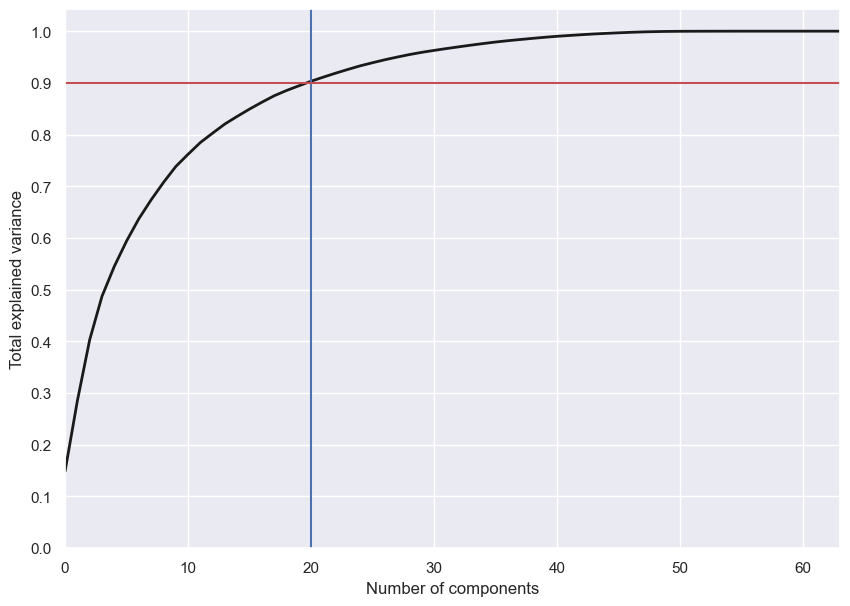

In [44]:
pca = PCA().fit(X)


plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0], c='b')
plt.axhline(0.9, c='r')
plt.show()

In [45]:
pca = PCA(0.9).fit(X)

print('We need %d components to explain 90%% of variance' 
      % pca.n_components_)

We need 21 components to explain 90% of variance


<a id="1.5"></a>
## 1.5. Предобработка данных

Метод главных компонент часто используется для предварительной обработки данных перед обучением классификатора. В качестве примера такого применения рассмотрим задачу о распознавании лиц. 

Для начала посмотрим на исходные данные.

In [46]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [47]:
%%time
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4, data_home='data/faces')

print('%d objects, %d features, %d classes' % (lfw_people.data.shape[0],
      lfw_people.data.shape[1], len(lfw_people.target_names)))
print('\nPersons:')
for name in lfw_people.target_names:
    print(name)
    

1560 objects, 1850 features, 12 classes

Persons:
Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Jacques Chirac
Jean Chretien
John Ashcroft
Junichiro Koizumi
Serena Williams
Tony Blair
CPU times: total: 8.61 s
Wall time: 4min 27s


In [48]:
for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


In [49]:
lfw_people.images[i].shape

(50, 37)

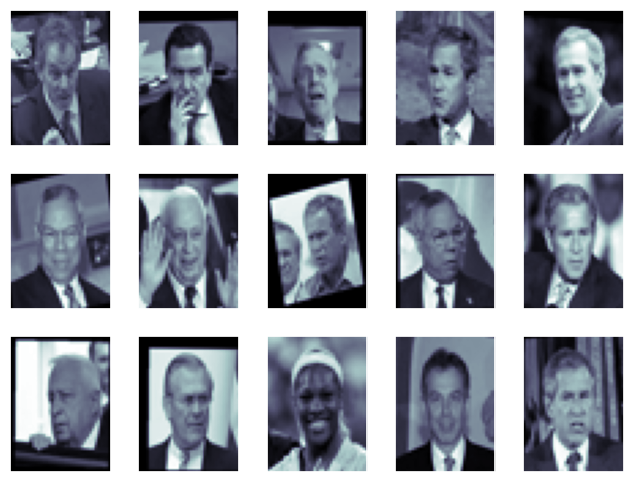

In [50]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

In [51]:
X_train, X_test, y_train, y_test = \
    train_test_split(lfw_people.data, lfw_people.target, random_state=0)

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Train size: 1170 Test size: 390


Вместо обычного PCA воспользуемся его приближенной версией (randomized PCA), которая позволяет существенно ускорить работу алгоритма на больших наборах данных. Выделим 100 главных компонент. Как видно, они объясняют более 90% дисперсии исходных данных.

100 principal components explain 90.28% of variance


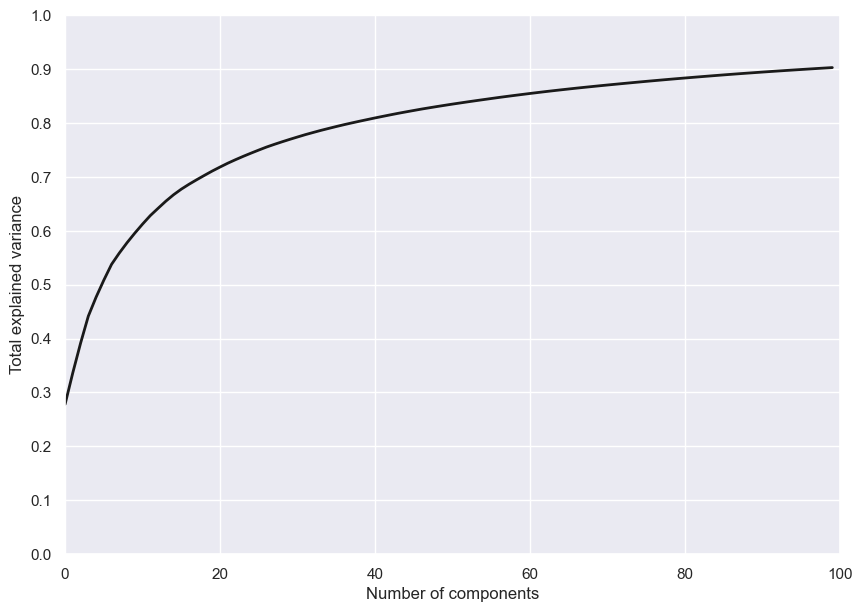

In [52]:
pca = PCA(n_components=100, svd_solver='randomized')
pca.fit(X_train)


print('100 principal components explain %.2f%% of variance' %
      (100 * np.cumsum(pca.explained_variance_ratio_)[-1]))
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=2, color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

Посмотрим на главные компоненты (или главные "лица"). Видим, что первые главные компоненты несут в себе информацию в основном об освещении на фотографии, в то время как оставшиеся выделяют какие-то отдельные черты человеческого лица - глаза, брови и другие.

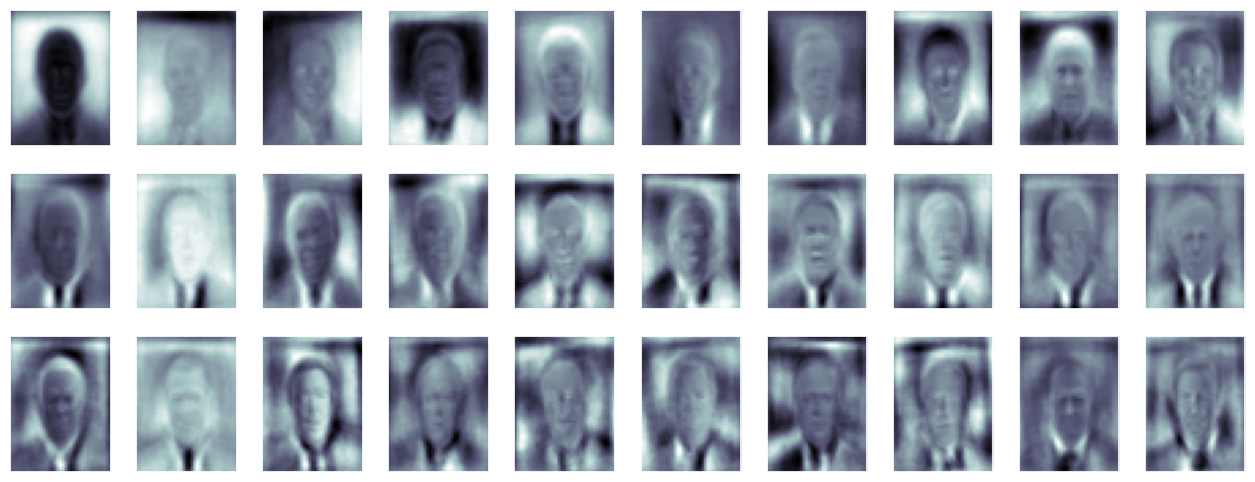

In [53]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap='bone')

PCA позволяет посмотреть на "среднее" лицо – тут считается среднее по каждому новому признаку.

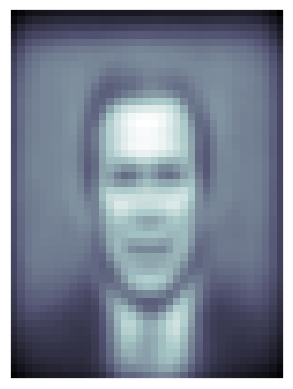

In [54]:
plt.imshow(pca.mean_.reshape((50, 37)), cmap='bone')
plt.xticks([])
plt.yticks([])
plt.show()

Перейдем теперь непосредственно к классификации. Мы сократили размерность данных (с 1850 признаков до 100), что позволяет существенно ускорить  работу стандартных алгоритмов обучения. Настроим SVM с RBF-ядром и посмотрим на результаты классификации.

In [55]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [56]:
%%time
model = SVC(kernel='rbf', C=100)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

CPU times: total: 578 ms
Wall time: 404 ms


In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

Accuracy: 0.661538
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.80      0.77        15
     Colin Powell       0.73      0.74      0.73        65
  Donald Rumsfeld       0.61      0.38      0.47        29
    George W Bush       0.67      0.92      0.78       133
Gerhard Schroeder       0.71      0.52      0.60        33
      Hugo Chavez       0.33      0.25      0.29        16
   Jacques Chirac       0.22      0.17      0.19        12
    Jean Chretien       0.25      0.10      0.14        10
    John Ashcroft       1.00      0.17      0.29        18
Junichiro Koizumi       0.86      0.55      0.67        11
  Serena Williams       1.00      0.84      0.91        19
       Tony Blair       0.47      0.55      0.51        29

         accuracy                           0.66       390
        macro avg       0.63      0.50      0.53       390
     weighted avg       0.67      0.66      0.64       390



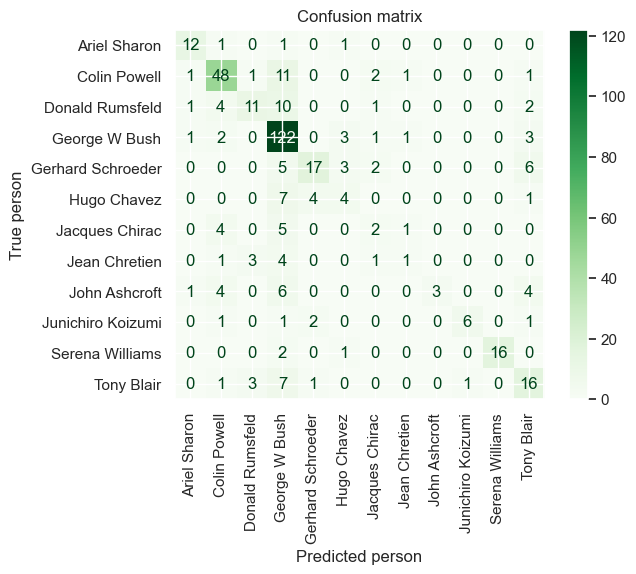

In [62]:
print("Accuracy: %f" % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))


M = confusion_matrix(y_test, y_pred, labels=model.classes_)
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]


disp = ConfusionMatrixDisplay(confusion_matrix=M,
                              display_labels=lfw_people.target_names)
disp.plot(cmap='Greens')
plt.xticks(ticks = range(len(lfw_people.target_names)), labels = lfw_people.target_names, rotation=90)
plt.yticks(ticks = range(len(lfw_people.target_names)), labels = lfw_people.target_names)

plt.ylabel('True person')
plt.xlabel('Predicted person')
plt.title('Confusion matrix')

plt.show()

16/(16+1)

In [63]:
%%time
model = SVC(kernel='rbf', C=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

CPU times: total: 2.83 s
Wall time: 3.15 s


In [64]:
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.715385


<a id="2"></a>
# 2. Сжатие изображений с помощью SVD
В этом упражнении вы должны изучить, как SVD можно использовать для сжатия изображений.

_Основано на открытом курсе по [Численной линейной алгебре](https://github.com/oseledets/nla2018 ) Ивана Оселедца_

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

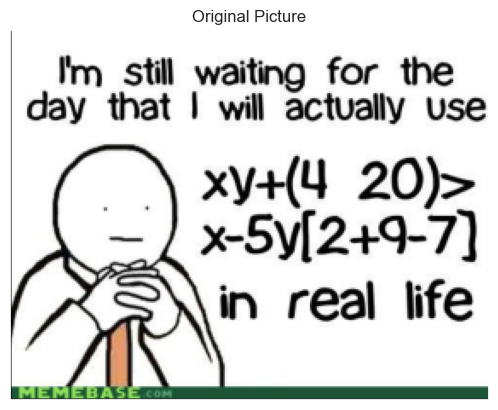

(217, 281, 3)


In [66]:
face_raw = Image.open("img/waiting.png")
face = np.array(face_raw).astype(np.uint8)[..., :3]

plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title("Original Picture")
plt.show()

print(face.shape)

In [67]:
# optional: zero mean the image
face_mean = (face - np.mean(face, axis=2, keepdims=True))

In [68]:
# Image is saved as a 3-dimensional array with shape H x W x C (heigt x width x channels)
Rf = face_mean[..., 0]
Gf = face_mean[..., 1]
Bf = face_mean[..., 2]

# Compute SVD and plot the singular values for different image channels
u, Rs, vh = np.linalg.svd(Rf, full_matrices=False)
u, Gs, vh = np.linalg.svd(Gf, full_matrices=False)
u, Bs, vh = np.linalg.svd(Bf, full_matrices=False)

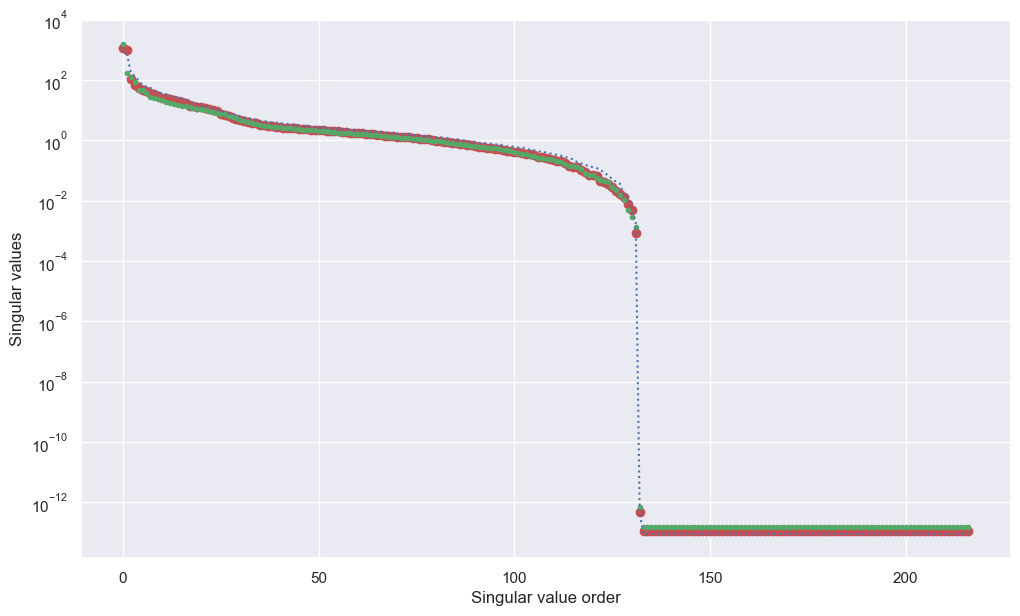

In [69]:
plt.figure(figsize=(12, 7))
plt.plot(Rs,'ro')
plt.plot(Gs,'g.')
plt.plot(Bs,'b:')
plt.yscale('log')
plt.ylabel("Singular values")
plt.xlabel("Singular value order")
plt.show()

Функция ```compress``` выполняет SVD и усекает его (используя $k$ сингулярные значения / векторы).

Обратите внимание, что в случае, когда ваши изображения не имеют оттенков серого, вам придется разделить ваше изображение на каналы и работать с матрицами, соответствующими разным каналам, отдельно.

In [70]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array):        input image (probably, colourful)
        
        k (int):                 approximation rank
        
    --------
    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array):              array of singular values 
    """
    image2 = image.copy()
    
    Rf = image2[..., 0]
    Gf = image2[..., 1]
    Bf = image2[..., 2]
    
    # compute per-channel SVD for input image
    u_r, Rs, vh_r = np.linalg.svd(Rf, full_matrices=False)
    u_g, Gs, vh_g = np.linalg.svd(Gf, full_matrices=False)
    u_b, Bs, vh_b = np.linalg.svd(Bf, full_matrices=False)
    
    Rs = Rs[:k]
    Gs = Gs[:k]
    Bs = Bs[:k]
    
    # reconstruct the input image with the given approximation rank
    reduced_im = np.zeros((image.shape))
    
    #print(u_r[:, :k].shape, np.diag(Rs).shape, vh_r[:k, :].shape)
    red_channel = u_r[:, :k] @ np.diag(Rs) @ vh_r[:k, :]
    green_channel = u_g[:, :k] @ np.diag(Gs) @ vh_g[:k, :]
    blue_channel = u_b[:, :k] @ np.diag(Bs) @ vh_b[:k, :]
    
    reduced_im[..., 0] = red_channel
    reduced_im[..., 1] = green_channel
    reduced_im[..., 2] = blue_channel
    reduced_im = (reduced_im - reduced_im.min()) / (reduced_im.max() - reduced_im.min())
    
    # save the array of top-k singular values
    s = np.zeros((len(Gs), 3))
    s[:, 0] = Rs
    s[:, 1] = Gs
    s[:, 2] = Bs
    
    return reduced_im, s

  0%|          | 0/9 [00:00<?, ?it/s]

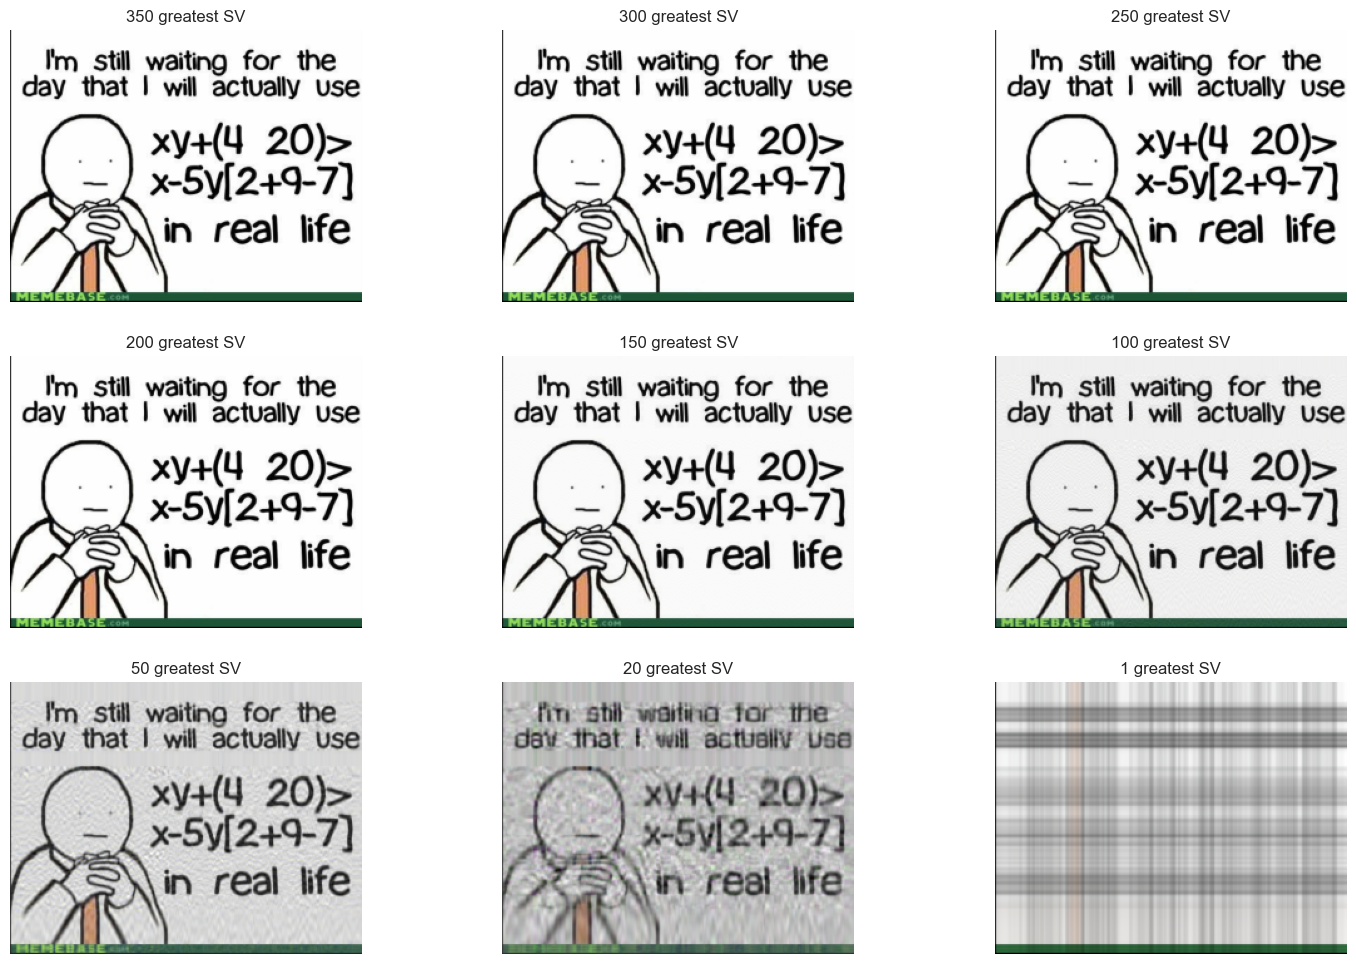

In [71]:
plt.figure(figsize=(18,12))
k_list = [350,300,250,200,150,100,50,20,1]

for i, k in tqdm(enumerate(k_list), total=len(k_list)):
    plt.subplot(3,3,i+1)
    im,s = compress(face,k)
    plt.imshow(im)
    plt.axis('off')
    plt.title("{} greatest SV".format(k))

Нарисуем следующие два рисунка для вашей любимой картинки
* Как относительная погрешность аппроксимации зависит от ранга аппроксимации?
* Как степень сжатия с точки зрения хранения информации ((сингулярные векторы + сингулярные числа) / общий размер изображения) зависит от ранга аппроксимации?

  0%|          | 0/56 [00:00<?, ?it/s]

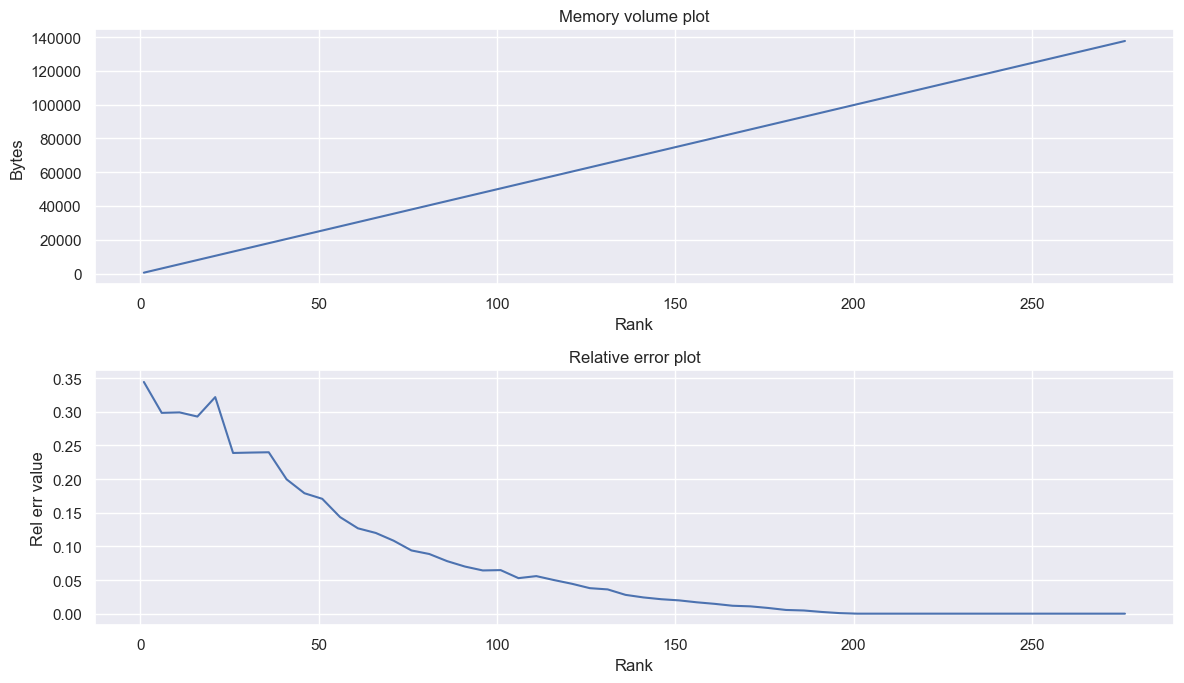

In [72]:
k_list = range(1, face.shape[1], 5)
rel_err = []
info = []
for k in tqdm(k_list, leave=False):
    img, s = compress(face, k)
    img *= 255
    h, w = img.shape[:2]
    
    current_relative_error = np.linalg.norm(img.astype(np.float64) - face.astype(np.float64)) # MSE(img, face) / l2_norm(face)
    current_relative_error /= np.linalg.norm(face.astype(np.float64))    
    current_information = k * (h + w + 1) # U(image_height x K) @ S(diag KxK) @ V^T(K x image_width)
    
    rel_err.append(current_relative_error)
    info.append(current_information)
    
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.title("Memory volume plot")
plt.xlabel("Rank")
plt.ylabel("Bytes")
plt.plot(k_list, info)

plt.subplot(2,1,2)
plt.title("Relative error plot")
plt.xlabel("Rank")
plt.ylabel("Rel err value")
plt.plot(k_list, rel_err)

plt.tight_layout()
plt.show()

<a id="3"></a>
# 3. Полезные ссылки 

**Что посмотреть?**
1. Реализация SVM с нуля: https://www.youtube.com/watch?v=T9UcK-TxQGw
2. Краткий и понтный вывод SVM: https://www.youtube.com/watch?v=ny1iZ5A8ilA&ab_channel=IntuitiveMachineLearning
3. Больше про то, как получается SVM с kernel: https://www.youtube.com/watch?v=Kwmgy0zt2hM&list=PLEqoHzpnmTfAVdVl2fH_je2_jWCEPAAqv&index=3&ab_channel=ФКНВШЭ
4. Как написать свой оптимизатор с помощью PyTorch: https://www.youtube.com/watch?v=zvp8K4iX2Cs&t=918s&ab_channel=mildlyoverfitted

**Что почитать?**
1. Визуализация работы SVM (основа семинара): https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
2. Документация sklearn по ядрам SVM: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py
3. Лекция по методу опорных векторов: http://www.ccas.ru/voron/download/SVM.pdf